# Spatial Averaging

Authors: [Tom Vo](https://github.com/tomvothecoder/) & [Stephen Po-Chedley](https://github.com/pochedls/)

Updated: 02/29/24 [xcdat v0.6.1]

Related APIs: [xarray.Dataset.spatial.average()](../generated/xarray.Dataset.spatial.average.rst) & [xarray.Dataset.spatial.get_weights()](../generated/xcdat.spatial.SpatialAccessor.rst#xcdat.spatial.SpatialAccessor.get_weights)


## Overview

A common data reduction in geophysical sciences is to produce spatial averages. Spatial averaging functionality in xcdat allows users to quickly produce area-weighted spatial averages for selected regions (or full dataset domains).

In the example below, we demonstrate the opening of a (remote) dataset and spatial averaging over the global, tropical, and Niño 3.4 domains.

The data used in this example is pulled directly from the [Earth System Grid Federation (ESGF)](https://aims2.llnl.gov/metagrid/search).

### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook_0.7.0 -c conda-forge xcdat=0.7.0 xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter
```

Then install the kernel from the `xcdat_notebook_0.7.0` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook_0.7.0`):

```bash
python -m ipykernel install --user --name xcdat_notebook_0.7.0 --display-name xcdat_notebook_0.7.0
```

Then to select the kernel `xcdat_notebook_0.7.0` in Jupyter to use the this kernel.


## 1. Open the `Dataset`

We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).


In [1]:
# parameters
import xcdat as xc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# specify file
filepath = "https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"

# open dataset
ds = xc.open_dataset(filepath)

# Unit adjust (-273.15, K to C)
ds["tas"] = ds.tas - 273.15

ds

<xarray.Dataset> Size: 221MB
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B 2.0
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 32kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 220MB -27.19 -27.19 ... -25.29 -25.29
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

## 2. Global average


In [2]:
# if you do not specify lat_bounds or lon_bounds, the averager will calculate the domain mean
ds_global_avg = ds.spatial.average("tas")

In [3]:
ds_global_avg.tas

<xarray.DataArray 'tas' (time: 1980)> Size: 16kB
array([12.52127071, 13.09115223, 13.60703132, ..., 15.5767848 ,
       14.65664621, 13.84951678])
Coordinates:
    height   float64 8B 2.0
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00

Text(0, 0.5, 'Near Surface Air Temperature [$^{\\circ}$C]')

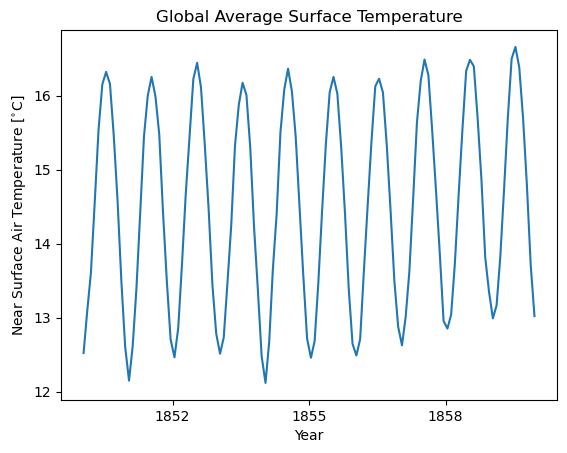

In [4]:
# Plot the first 120 time steps
ds_global_avg.tas.isel(time=slice(0, 120)).plot()
plt.title("Global Average Surface Temperature")
plt.xlabel("Year")
plt.ylabel("Near Surface Air Temperature [$^{\\circ}$C]")

## 3. Tropical average


In [5]:
# compute the tropical average
ds_trop_avg = ds.spatial.average("tas", lat_bounds=(-25, 25))

Text(0, 0.5, 'Near Surface Air Temperature [$^{\\circ}$C]')

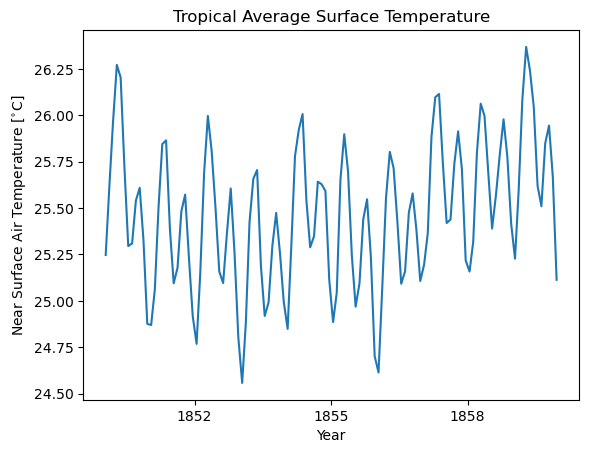

In [6]:
# Plot the first 120 time steps
ds_trop_avg.tas.isel(time=slice(0, 120)).plot()
plt.title("Tropical Average Surface Temperature")
plt.xlabel("Year")
plt.ylabel("Near Surface Air Temperature [$^{\\circ}$C]")

## 4. Nino 3.4 Region

> Niño 3.4 (5N-5S, 170W-120W): The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more."
>
> &mdash; <cite>https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni</cite>


In [7]:
# compute the nino 3.4 average
ds_nino_avg = ds.spatial.average("tas", lat_bounds=(-5, 5), lon_bounds=(190, 240))

Text(0, 0.5, 'Near Surface Air Temperature [$^{\\circ}$C]')

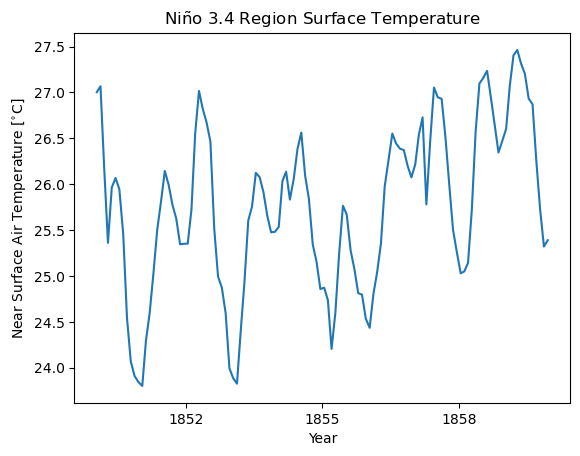

In [8]:
# Plot the first 120 time steps
ds_nino_avg.tas.isel(time=slice(0, 120)).plot()
plt.title("Ni$\\mathrm{\\tilde{n}}$o 3.4 Region Surface Temperature")
plt.xlabel("Year")
plt.ylabel("Near Surface Air Temperature [$^{\\circ}$C]")

## 5. Retain / Inspect Spatial Weights

xCDAT can retain the weights used for spatial averaging using `keep_weights=True`. Here we retain and inspect these weights for the Niño 3.4 region. Note that along the edges of the Niño 3.4 box the weights are slightly less (since some grid cells are not fully in the averaging box and thus receive partial weight).


In [9]:
# recompute the nino 3.4 average, but retain weights
ds_nino_avg = ds.spatial.average(
    "tas", lat_bounds=(-5, 5), lon_bounds=(190, 240), keep_weights=True
)

Text(0.5, 1.0, 'Nino 3.4 Weights')

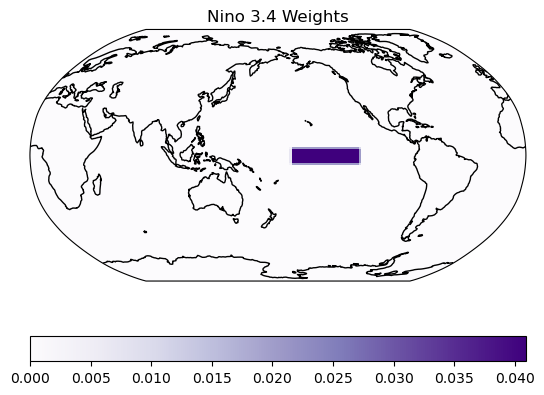

In [10]:
# plot the weights
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180.0))
plt.pcolor(
    ds_nino_avg.lon,
    ds_nino_avg.lat,
    ds_nino_avg.lat_lon_wts.T,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.Purples,
)
ax.coastlines()
plt.colorbar(orientation="horizontal")
plt.title("Nino 3.4 Weights")

## 6. Create and apply your own weights

Instead of having xcdat generate geospatial weights, you may want to create your own weights. You can pass your own weights into xcdat. Here we show an example of weighting the surface temperature data in the tropics by precipitation.

<div class="alert alert-block alert-warning"><b>Warning:</b> The lat_bounds and lon_bounds args are used when calculating axis weights, but is ignored if weights are supplied.</div>


In [11]:
# let's grab and open the precipitation dataset that corresponds to our temperature data
filepath = "https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/pr/gn/v20200605/pr_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"
ds_pr = xc.open_dataset(filepath)

In [12]:
# we will use the precip data as weights (zeroing out extratropical data)
weights = ds_pr.pr.where(np.abs(ds_pr.pr.lat) < 30, 0.0)
# and apply a cos(lat) weighting
weights = weights * np.cos(np.radians(ds_pr.lat))
# compute precipitation weighted temperature
ds_pw = ds.spatial.average("tas", weights=weights)

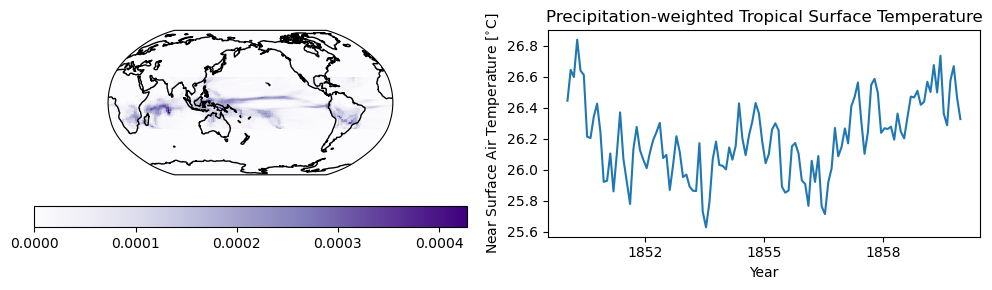

In [13]:
# plot the first timestep of the weights matrix
plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.pcolor(
    ds_pr.lon, ds_pr.lat, weights[0], transform=ccrs.PlateCarree(), cmap=plt.cm.Purples
)
ax.coastlines()
plt.colorbar(orientation="horizontal", ticks=[0, 0.0001, 0.0002, 0.0003, 0.0004])
plt.subplot(1, 2, 2)
plt.title("Weights (time=")

# plot the first 120 time steps
ds_pw.tas[0:120].plot()
plt.title("Precipitation-weighted Tropical Surface Temperature")
plt.xlabel("Year")
plt.ylabel("Near Surface Air Temperature [$^{\\circ}$C]")
plt.tight_layout()

## 7. Compute a zonal average

You do not need to average over both latitude and longitude. Here we show an example in which we take the zonal average (average over all longitude values).


In [14]:
# take zonal average
ds_zonal = ds.spatial.average("tas", axis=["X"])

Text(0.5, 1.0, 'Zonal Mean Surface Air Temperature')

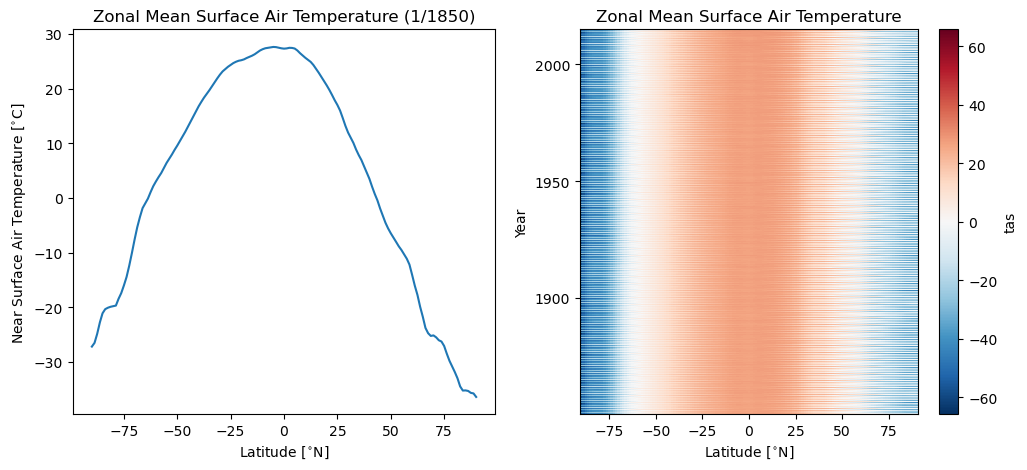

In [15]:
# plot first time step
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ds_zonal.tas[0].plot()
plt.ylabel("Near Surface Air Temperature [$^{\\circ}$C]")
plt.xlabel("Latitude [$^{\\circ}$N]")
plt.title("Zonal Mean Surface Air Temperature (1/1850)")

# plot hovmoller
plt.subplot(1, 2, 2)
ds_zonal.tas.plot()
plt.xlabel("Latitude [$^{\\circ}$N]")
plt.ylabel("Year")
plt.title("Zonal Mean Surface Air Temperature")